# Base de dados e importações

In [ ]:
!gdown --id 1lCN31ttToSzd28leuD1B9VbFtTUaWbfU --output dados.zip
!unzip dados.zip
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: melspectograma/24f7177c-c147-4ea8-9a9e-6f273d4f6fe4.jpg  
  inflating: melspectograma/9cefcba6-bea1-4131-a905-3d28e567344b.jpg  
  inflating: melspectograma/a4468aa1-4ce9-4965-a8c2-5b1860e1274d.jpg  
  inflating: melspectograma/bc36aed7-62e4-403d-992d-eb186cf2ccc1.jpg  
  inflating: melspectograma/da13dce6-31c9-411d-8ac6-3163892b9f8d.jpg  
  inflating: melspectograma/72418df9-2a0a-4da5-922d-7a1d5d12ab80.jpg  
  inflating: melspectograma/416c24b9-c0cc-4071-b55f-70ed103e02bc.jpg  
  inflating: melspectograma/901961a0-1c48-4a41-b247-1ff7034ed97d.jpg  
  inflating: melspectograma/3c46fbfe-cec8-41b3-9360-9e3e75a784de.jpg  
  inflating: melspectograma/21fc5063-f772-45be-992a-7af2b977ab12.jpg  
  inflating: melspectograma/3ba36da8-a4af-4dce-ad62-d3398d4c9cd5.jpg  
  inflating: melspectograma/5157deaa-f5f3-4a49-97ef-cd7ae396d446.jpg  
  inflating: melspectograma/70e16d99-c4b2-4d6b-a7c2-8d6b7e8fe68a.jpg  
  inflating: melsp

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train_aug = pd.read_csv('/content/CSV/train_additional_data.csv')
train = pd.concat([train, train_aug])
train

,original_index,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,cough_type_3,diagnosis_3,severity_3
0,12581,a084b953-189d-422d-a40a-b545b4f01618,2020-04-03T09:30:06.071538+00:00,0.8629,NaN,NaN,27.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,False,False,False,True,dry,lower_infection,mild
1,8700,6dff10f3-5df0-4b5a-be62-613afd6115dc,2020-04-24T19:00:52.634932+00:00,0.9948,41.7,2.8,57.0,male,False,False,healthy,ok,dry,False,False,False,False,False,True,healthy_cough,pseudocough,good,dry,False,True,False,False,False,False,obstructive_disease,mild,good,False,False,False,False,False,True,wet,lower_infection,mild
2,555,075cdb5a-5c29-4266-84ea-c44963bd0454,2020-04-11T16:58:29.950572+00:00,0.9961,NaN,NaN,29.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ok,dry,False,False,False,False,True,False,upper_infection,pseudocough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18845,f0da0dd1-a4d1-47ac-bc31-e9c6ceb05e28,2020-05-12T09:56:47.381630+00:00,0.9624,NaN,NaN,44.0,male,False,False,healthy,ok,wet,False,False,False,False,False,True,lower_infection,mild,ok,wet,False,False,False,True,False,False,lower_infection,mild,good,False,False,False,False,False,True,wet,lower_infection,mild
4,7553,5fe2cece-1061-4f53-b4ac-64a07efc6ba1,2020-04-11T20:33:24.800041+00:00,953.0000,40.4,-3.7,49.0,male,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ok,dry,False,False,False,False,False,True,upper_infection,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,20064,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,2020-04-22T05:40:51.730942+00:00,0.5591,13.0,77.6,26.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7010,20065,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,2020-06-05T03:41:37.481463+00:00,0.9498,-34.5,-58.5,23.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7011,20066,ffeea120-92a4-40f9-b692-c3865c7a983f,2020-05-02T10:18:27.348859+00:00,0.9784,14.3,121.1,22.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7012,20067,fff13fa2-a725-49ef-812a-39c6cedda33d,2020-04-13T17:51:36.956822+00:00,0.7154,31.9,34.7,21.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2










In [ ]:
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.jpg'
val['uuid'] = val['uuid'] + '.jpg'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.0
*   symptomatic -  represenatado pelo 1 - ficou com o peso 5.826048171275647 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 13.807610993657505

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.0, 1: 5.826048171275647, 2: 13.807610993657505}

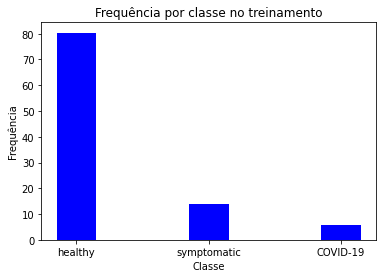

In [ ]:
plt.bar(0, len(train.values[train.classInt.values == 0])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(1, len(train.values[train.classInt.values == 1])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(2, len(train.values[train.classInt.values == 2])/len(train.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no treinamento')
plt.savefig('Treinamento-aumentacao.png')

# Função para treinamento de modelos


Como foi analisado que a execução de uma época da rede dura poucos segundos iremos testar a base com esse pré-processamento em 21 redes diferentes da imagenet para ver qual obteve a melhor acurácia tornando-a por fim o nosso baseline inicial. As redes a serem analisadas são listadas abaixo:

ResNet50
ResNet101	
ResNet152	
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5	
EfficientNetB6	
EfficientNetB7	
MobileNet	
MobileNetV2	
DenseNet121	
DenseNet169	
DenseNet201	
InceptionV3	
InceptionResNetV2	
Xception	
VGG16	
VGG19	

A seguir temos uma função genérica onde suporta a chamada de várias redes da imagenet, para facilitar a criação dos modelos junto com o conjunto de parâmetros relacionados a cada uma delas.

In [ ]:
def cria_e_treina_rede(model_name, train_df, val_df, batch_size=32, callbacks=[], image_size=(256, 256), pooling='avg', loss='categorical_crossentropy', epochs=500, class_weights=class_weights, trainable=True):

  if model_name == 'resnet50' or model_name == 'resnet101' or model_name == 'resnet152':
    preprocessing_function = tf.keras.applications.resnet.preprocess_input
  elif model_name == 'efficientnetb0' or model_name == 'efficientnetb1' or model_name == 'efficientnetb2' or model_name == 'efficientnetb3' or model_name == 'efficientnetb4' or model_name == 'efficientnetb5'  or model_name == 'efficientnetb6' or model_name == 'efficientnetb7':
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
  elif model_name == 'mobilenet':
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input
  elif model_name == 'mobilenetv2':
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
  elif model_name == 'densenet121' or model_name == 'densenet169' or model_name == 'densenet201':
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
  elif model_name == 'inceptionv3':
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
  elif model_name == 'inceptionresnetv2':
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input
  elif model_name == 'xception':
    preprocessing_function = tf.keras.applications.xception.preprocess_input
  elif model_name == 'vgg16':
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
  elif model_name == 'vgg19':
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing_function,
  )

  train_generator = datagen.flow_from_dataframe(
    train_df, directory='/content/melspectograma', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42, color_mode='rgb')

  val_generator = datagen.flow_from_dataframe(
    val_df, directory='/content/melspectograma', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=False, seed=42, color_mode='rgb')
  
  if model_name == 'resnet50':
    pre_trained = tf.keras.applications.ResNet50(include_top=False, pooling=pooling)
  elif model_name == 'resnet101':
    pre_trained = tf.keras.applications.ResNet101(include_top=False, pooling=pooling)
  elif model_name == 'resnet152':
    pre_trained = tf.keras.applications.ResNet152(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb0':
    pre_trained = tf.keras.applications.EfficientNetB0(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb1':
    pre_trained = tf.keras.applications.EfficientNetB1(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb2':
    pre_trained = tf.keras.applications.EfficientNetB2(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb3':
    pre_trained = tf.keras.applications.EfficientNetB3(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb4':
    pre_trained = tf.keras.applications.EfficientNetB4(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb5':
    pre_trained = tf.keras.applications.EfficientNetB5(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb6':
    pre_trained = tf.keras.applications.EfficientNetB6(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb7':
    pre_trained = tf.keras.applications.EfficientNetB7(include_top=False, pooling=pooling)
  elif model_name == 'mobilenet':
    pre_trained = tf.keras.applications.MobileNet(include_top=False, pooling=pooling)
  elif model_name == 'mobilenetv2':
    pre_trained = tf.keras.applications.MobileNetV2(include_top=False, pooling=pooling)
  elif model_name == 'densenet121':
    pre_trained = tf.keras.applications.DenseNet121(include_top=False, pooling=pooling)
  elif model_name == 'densenet169':
    pre_trained = tf.keras.applications.DenseNet169(include_top=False, pooling=pooling)
  elif model_name == 'densenet201':
    pre_trained = tf.keras.applications.DenseNet201(include_top=False, pooling=pooling)
  elif model_name == 'inceptionv3':
    pre_trained = tf.keras.applications.InceptionV3(include_top=False, pooling=pooling)
  elif model_name == 'inceptionresnetv2':
    pre_trained = tf.keras.applications.InceptionResNetV2(include_top=False, pooling=pooling)
  elif model_name == 'xception':
    pre_trained = tf.keras.applications.Xception(include_top=False, pooling=pooling)
  elif model_name == 'vgg16':
    pre_trained = tf.keras.applications.VGG16(include_top=False, pooling=pooling)
  elif model_name == 'vgg19':
    pre_trained = tf.keras.applications.VGG19(include_top=False, pooling=pooling)

  for layer in pre_trained.layers:
    layer.treinable = trainable

  model = tf.keras.models.Sequential([
   pre_trained,
   tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.summary()

  optimizer = tf.keras.optimizers.Adam(0.000001)

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))
  if 'checkpoint' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('/content/' + model_name + '.hdf5', save_best_only=True, verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(model_name + ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  predict_val = model.predict(val_generator, verbose=1)
  y_true = []

  i = 0
  for batch, label in val_generator:
    i += batch.shape[0]
    for l in np.argmax(label, axis=1):
      y_true.append(l)
    if i == len(val_df): break

  y_true = np.array(y_true)

  print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

  cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
  cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cm) / 3
  print('Acuracia balanceada na validacao:', balanced_acc)

  return model

# Modelos

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 63s 228ms/step - loss: 3.3872 - acc: 0.7569 - val_loss: 1.2612 - val_acc: 0.3525
Epoch 2/500
254/254 [==============================] - 57s 225ms/step - loss: 2.8197 - acc: 0.6521 - val_loss: 1.1734 - val_acc: 0.3345
Epoch 3/500
254/254 [==============================] - 57s 225ms/step - loss: 2.5899 - acc: 0.5642 - val_l

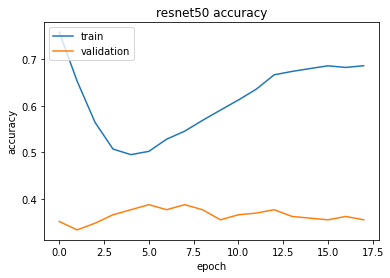

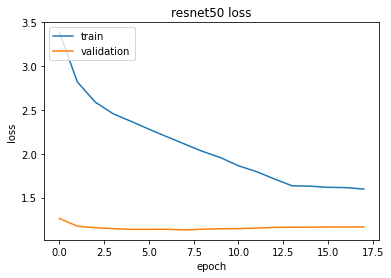

9/9 [==============================] - 1s 74ms/step
[[50 17 21]
 [47 39 21]
 [39 25 19]]
Acuracia balanceada na validacao: 0.3871944873802773


In [ ]:
cria_e_treina_rede('resnet50', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 6147      
Total params: 42,664,323
Trainable params: 42,558,979
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 103s 371ms/step - loss: 2.8950 - acc: 0.3813 - val_loss: 1.1996 - val_acc: 0.3453
Epoch 2/500
254/254 [==============================] - 93s 366ms/step - loss: 2.6506 - acc: 0.3961 - val_loss: 1.1622 - val_acc: 0.3561
Epoch 3/500
254/254 [==============================] - 93s 366ms/step - loss: 2.4822 - acc: 0.4139 - val

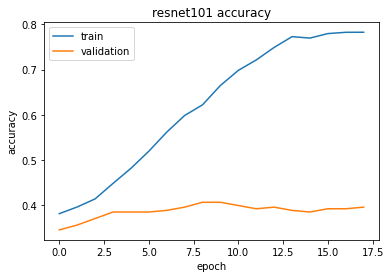

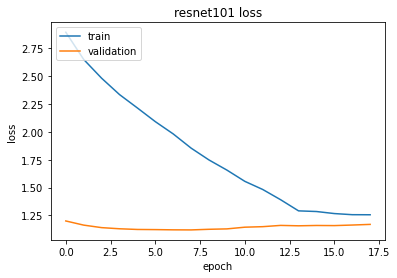

9/9 [==============================] - 2s 115ms/step
[[46 28 14]
 [51 38 18]
 [39 18 26]]
Acuracia balanceada na validacao: 0.3970401572304511


In [ ]:
cria_e_treina_rede('resnet101', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
234700800/234698864 [==============================] - 3s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 6147      
Total params: 58,377,091
Trainable params: 58,225,667
Non-trainable params: 151,424
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 148s 530ms/step - loss: 3.4602 - acc: 0.1415 - val_loss: 1.3591 - val_acc: 0.2950
Epoch 2/500
254/254 [==============================] - 132s 521ms/step - loss: 2.8057 - acc: 0.2790 - val_loss: 1.2011 - val_acc: 0.2842
Epoch 3/500
254/254 [===============

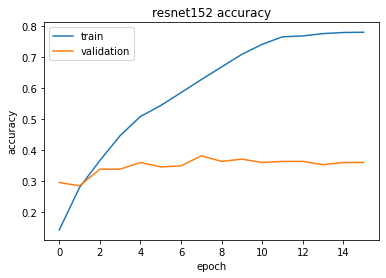

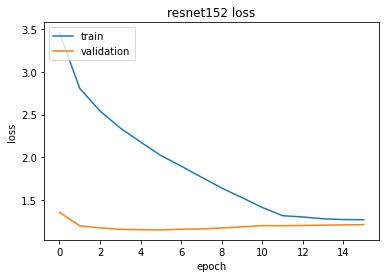

9/9 [==============================] - 3s 162ms/step
[[39 24 25]
 [43 35 29]
 [43 18 22]]
Acuracia balanceada na validacao: 0.3451149542946638


In [ ]:
cria_e_treina_rede('resnet152', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
254/254 [==============================] - 95s 286ms/step - loss: 2.7418 - acc: 0.3093 - val_loss: 1.1159 - val_acc: 0.3849
Epoch 2/500
254/254 [======================

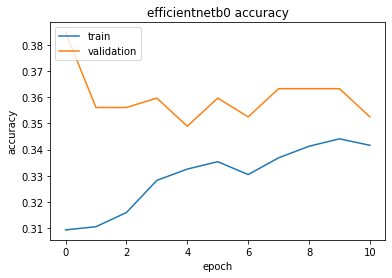

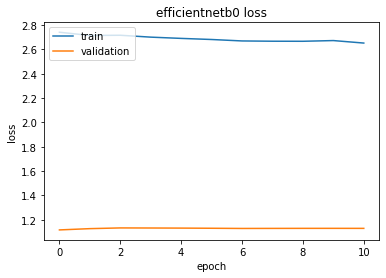

9/9 [==============================] - 2s 60ms/step
[[ 9 64 15]
 [ 8 82 17]
 [ 9 58 16]]
Acuracia balanceada na validacao: 0.35379965059899754


In [ ]:
cria_e_treina_rede('efficientnetb0', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
27025408/27018416 [==============================] - 0s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 3843      
Total params: 6,579,082
Trainable params: 6,517,027
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 115s 417ms/step - loss: 2.7334 - acc: 0.2887 - val_loss: 1.1443 - val_acc: 0.3309
Epoch 2/500
254/254 [==============================] - 104s 411ms/step - loss: 2.7192 - acc: 0.3047 - val_loss: 1.1315 - val_acc: 0.3345
Epoch 3/500
254/254 [====================

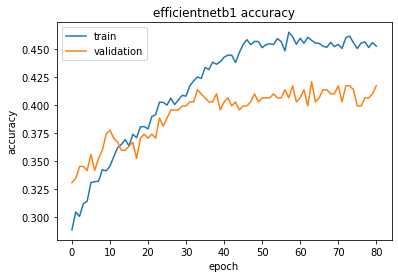

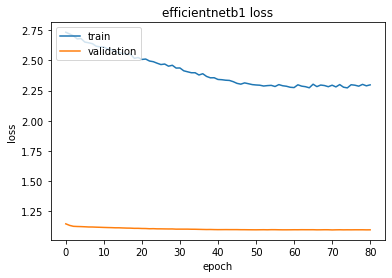

9/9 [==============================] - 2s 64ms/step
[[42 31 15]
 [40 40 27]
 [29 20 34]]
Acuracia balanceada na validacao: 0.42024768573017646


In [ ]:
cria_e_treina_rede('efficientnetb1', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
31793152/31790344 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 4227      
Total params: 7,772,796
Trainable params: 7,705,221
Non-trainable params: 67,575
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 120s 433ms/step - loss: 2.7888 - acc: 0.3782 - val_loss: 1.1617 - val_acc: 0.3094
Epoch 2/500
254/254 [==============================] - 108s 424ms/step - loss: 2.7620 - acc: 0.3745 - val_loss: 1.1726 - val_acc: 0.3165
Epoch 3/500
254/254 [====================

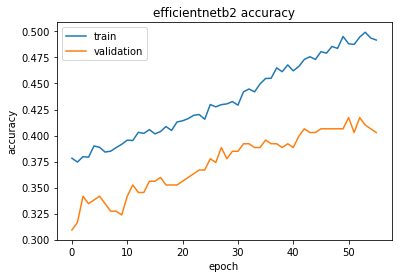

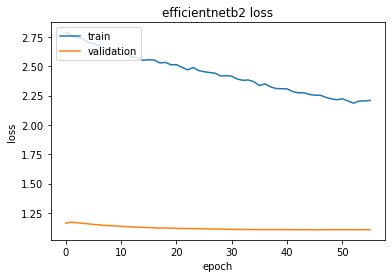

9/9 [==============================] - 2s 65ms/step
[[44 33 11]
 [37 40 30]
 [29 25 29]]
Acuracia balanceada na validacao: 0.40774312202079344


In [ ]:
cria_e_treina_rede('efficientnetb2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
43941888/43941136 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 4611      
Total params: 10,788,146
Trainable params: 10,700,843
Non-trainable params: 87,303
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 145s 527ms/step - loss: 2.8042 - acc: 0.3420 - val_loss: 1.0951 - val_acc: 0.4065
Epoch 2/500
254/254 [==============================] - 131s 514ms/step - loss: 2.7674 - acc: 0.3488 - val_loss: 1.1362 - val_acc: 0.3201
Epoch 3/500
254/254 [==================

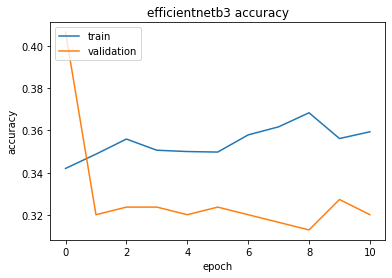

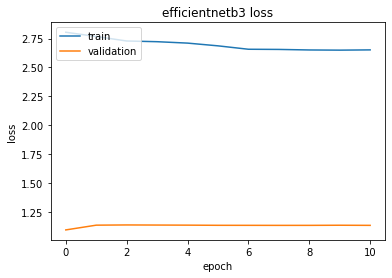

9/9 [==============================] - 2s 80ms/step
[[41 39  8]
 [39 52 16]
 [32 31 20]]
Acuracia balanceada na validacao: 0.39761808491399747


In [ ]:
cria_e_treina_rede('efficientnetb3', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
71688192/71686520 [==============================] - 1s 0us/step
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 5379      
Total params: 17,679,202
Trainable params: 17,553,995
Non-trainable params: 125,207
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 179s 650ms/step - loss: 2.7076 - acc: 0.3634 - val_loss: 1.1232 - val_acc: 0.3381
Epoch 2/500
254/254 [==============================] - 162s 638ms/step - loss: 2.6913 - acc: 0.3658 - val_loss: 1.1142 - val_acc: 0.3597
Epoch 3/500
254/254 [================

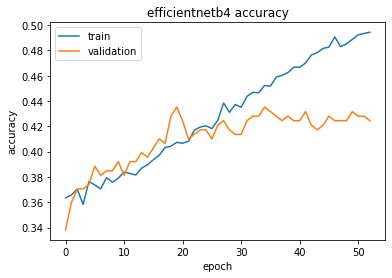

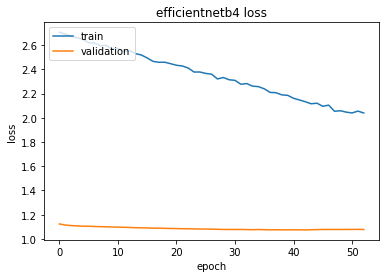

9/9 [==============================] - 3s 102ms/step
[[37 29 22]
 [20 54 33]
 [26 31 26]]
Acuracia balanceada na validacao: 0.41279348489966666


In [ ]:
cria_e_treina_rede('efficientnetb4', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
115269632/115263384 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 28,519,674
Trainable params: 28,346,931
Non-trainable params: 172,743
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
508/508 [==============================] - 209s 341ms/step - loss: 2.7068 - acc: 0.3977 - val_loss: 1.1292 - val_acc: 0.2950
Epoch 2/500
508/508 [================

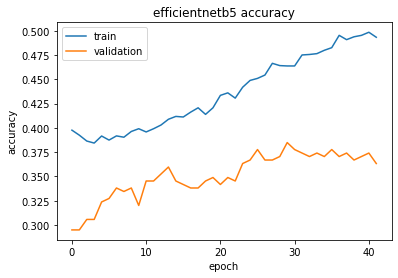

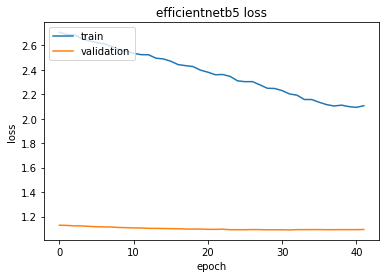

18/18 [==============================] - 4s 48ms/step
[[28 28 32]
 [40 45 22]
 [33 19 31]]
Acuracia balanceada na validacao: 0.37074551391632804


In [ ]:
cria_e_treina_rede('efficientnetb5', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
165240832/165234480 [==============================] - 2s 0us/step
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 2304)              40960143  
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 6915      
Total params: 40,967,058
Trainable params: 40,742,619
Non-trainable params: 224,439
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 325s 597ms/step - loss: 2.7230 - acc: 0.2530 - val_loss: 1.1232 - val_acc: 0.3273
Epoch 2/500
508/508 [==============================] - 299s 589ms/step - loss: 2.6862 - acc: 0.2614 - val_loss: 1.1216 - val_acc: 0.3129
Epoch 3/500
508/508 [==============

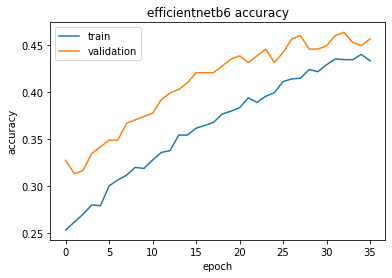

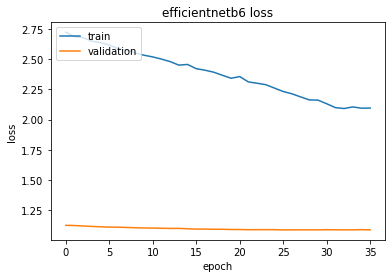

18/18 [==============================] - 5s 101ms/step
[[37 33 18]
 [27 48 32]
 [20 25 38]]
Acuracia balanceada na validacao: 0.4422946671989572


In [ ]:
cria_e_treina_rede('efficientnetb6', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
258080768/258076736 [==============================] - 2s 0us/step
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 2560)              64097687  
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 7683      
Total params: 64,105,370
Trainable params: 63,794,643
Non-trainable params: 310,727
_________________________________________________________________
Epoch 1/500
1016/1016 [==============================] - 488s 455ms/step - loss: 2.6769 - acc: 0.3051 - val_loss: 1.1068 - val_acc: 0.3489
Epoch 2/500
1016/1016 [==============================] - 457s 450ms/step - loss: 2.6526 - acc: 0.3087 - val_loss: 1.1007 - val_acc: 0.3597
Epoch 3/500
1016/1016 [========

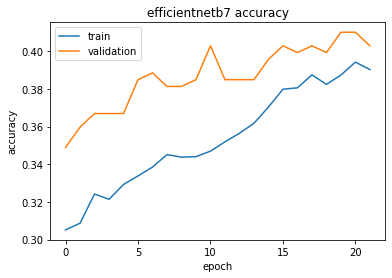

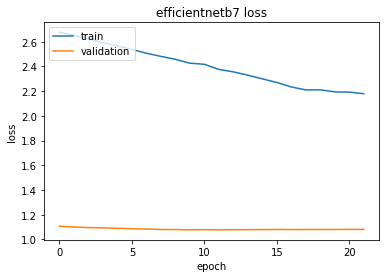

35/35 [==============================] - 6s 77ms/step
[[23 22 43]
 [22 45 40]
 [25 19 39]]
Acuracia balanceada na validacao: 0.38393463403315903


In [ ]:
cria_e_treina_rede('efficientnetb7', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=8)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
254/254 [==============================] - 56s 150ms/step - loss: 3.2944 - acc: 0.5814 - val_loss: 1.3700 - val_acc: 0.3345
Epoch 2/500
254/254 [======================

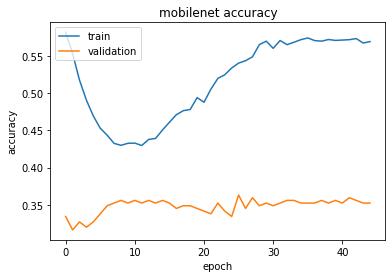

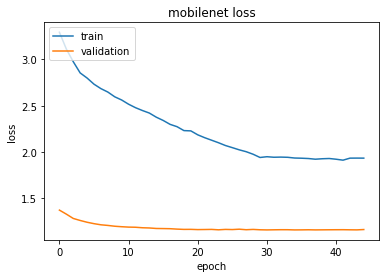

9/9 [==============================] - 1s 60ms/step
[[40 28 20]
 [50 41 16]
 [44 22 17]]
Acuracia balanceada na validacao: 0.34751410058244875


In [ ]:
cria_e_treina_rede('mobilenet', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 44s 159ms/step - loss: 3.1981 - acc: 0.6929 - val_loss: 2.0499 - val_acc: 0.3201
Epoch 2/500
254/254 [==============================] - 39s 154ms/step - loss: 3.0428 - acc: 0.6409 - val_loss: 1.7534 - val_acc: 0.3129
Epoch 3/500
254/254 [========================

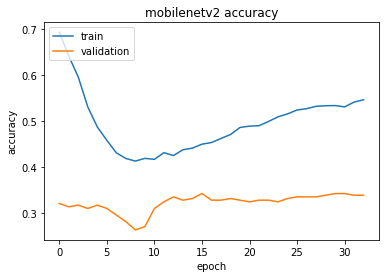

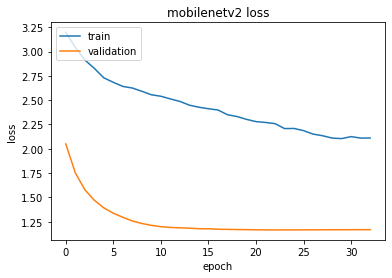

9/9 [==============================] - 1s 63ms/step
[[40 27 21]
 [48 32 27]
 [37 27 19]]
Acuracia balanceada na validacao: 0.32750884591893487


In [ ]:
cria_e_treina_rede('mobilenetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
29089792/29084464 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 56s 176ms/step - loss: 2.9522 - acc: 0.2107 - val_loss: 1.1792 - val_acc: 0.3597
Epoch 2/500
254/254 [==============================] - 41s 161ms/step - loss: 2.8094 - acc: 0.2332 - val_loss: 1.1695 - val_acc: 0.3669
Epoch 3/500
254/254 [======================

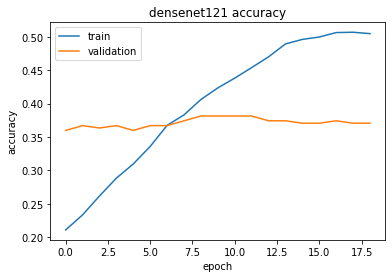

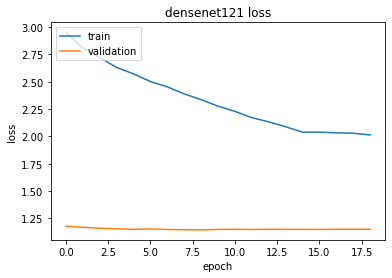

9/9 [==============================] - 2s 80ms/step
[[29 33 26]
 [29 49 29]
 [25 30 28]]
Acuracia balanceada na validacao: 0.3749462591231536


In [ ]:
cria_e_treina_rede('densenet121', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
51879936/51877672 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 12,489,475
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 68s 213ms/step - loss: 2.8696 - acc: 0.4672 - val_loss: 1.1663 - val_acc: 0.3597
Epoch 2/500
254/254 [==============================] - 51s 201ms/step - loss: 2.7261 - acc: 0.4554 - val_loss: 1.1503 - val_acc: 0.3669
Epoch 3/500
254/254 [===================

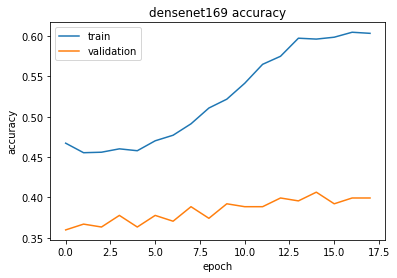

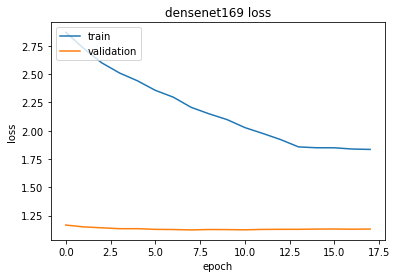

9/9 [==============================] - 3s 96ms/step
[[43 28 17]
 [40 43 24]
 [41 20 22]]
Acuracia balanceada na validacao: 0.38518858782624127


In [ ]:
cria_e_treina_rede('densenet169', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
74842112/74836368 [==============================] - 3s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 18,098,691
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 98s 158ms/step - loss: 2.8293 - acc: 0.1948 - val_loss: 1.1431 - val_acc: 0.3381
Epoch 2/500
508/508 [==============================] - 75s 148ms/step - loss: 2.6572 - acc: 0.2518 - val_loss: 1.1347 - val_acc: 0.3669
Epoch 3/500
508/508 [===================

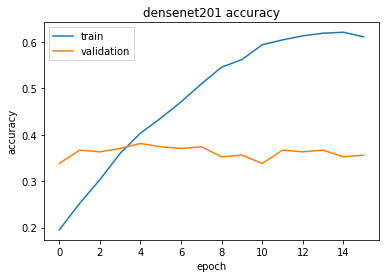

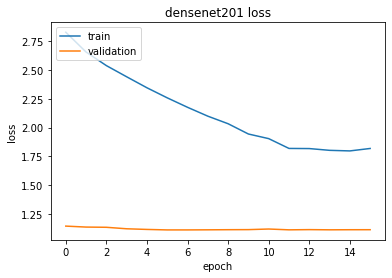

18/18 [==============================] - 4s 54ms/step
[[39 27 22]
 [35 36 36]
 [30 24 29]]
Acuracia balanceada na validacao: 0.3763426688913684


In [ ]:
cria_e_treina_rede('densenet201', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 48s 82ms/step - loss: 2.7224 - acc: 0.4420 - val_loss: 1.1564 - val_acc: 0.3094
Epoch 2/500
508/508 [==============================] - 39s 77ms/step - loss: 2.6627 - acc: 0.4102 - val_loss: 1.1385 - val_acc: 0.3489
Epoch 3/500
508/508 [======================

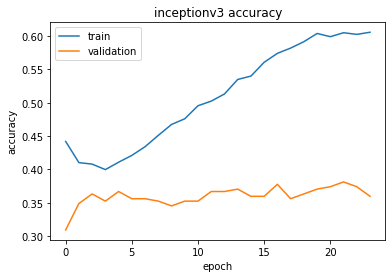

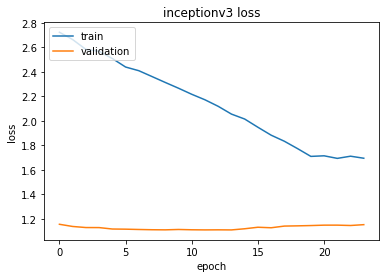

18/18 [==============================] - 2s 36ms/step
[[32 26 30]
 [35 43 29]
 [35 20 28]]
Acuracia balanceada na validacao: 0.3676183067017433


In [ ]:
cria_e_treina_rede('inceptionv3', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
219062272/219055592 [==============================] - 5s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 92s 300ms/step - loss: 2.8173 - acc: 0.1407 - val_loss: 1.1399 - val_acc: 0.3345
Epoch 2/500
254/254 [==============================] - 72s 282ms/step - loss: 2.7169 - acc: 0.1589 - val_loss: 1.1222 - val_acc: 0.3489
Epoch 3/500
254/254 [==================

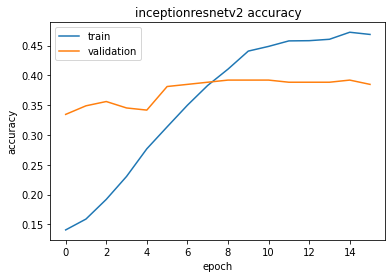

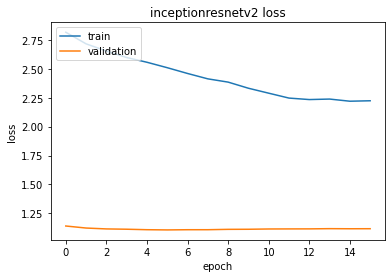

9/9 [==============================] - 3s 88ms/step
[[31 33 24]
 [28 55 24]
 [21 42 20]]
Acuracia balanceada na validacao: 0.36908509142773305


In [ ]:
cria_e_treina_rede('inceptionresnetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 91s 342ms/step - loss: 2.6575 - acc: 0.4421 - val_loss: 1.1132 - val_acc: 0.3345
Epoch 2/500
254/254 [==============================] - 85s 334ms/step - loss: 2.6397 - acc: 0.4399 - val_loss: 1.1131 - val_acc: 0.3381
Epoch 3/500
254/254 [====================

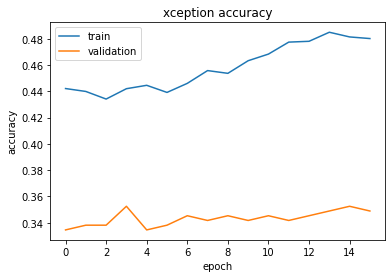

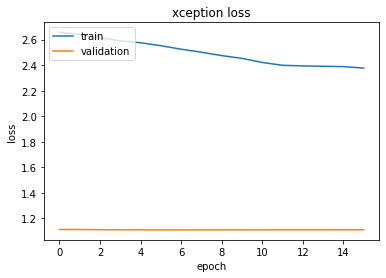

9/9 [==============================] - 1s 71ms/step
[[26 26 36]
 [34 37 36]
 [34 18 31]]
Acuracia balanceada na validacao: 0.3382476379605081


In [ ]:
cria_e_treina_rede('xception', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 50s 92ms/step - loss: 3.6842 - acc: 0.3250 - val_loss: 1.2973 - val_acc: 0.2806
Epoch 2/500
508/508 [==============================] - 44s 87ms/step - loss: 2.7640 - acc: 0.3446 - val_loss: 1.1905 - val_acc: 0.2986
Epoch 3/500
508/508 [===========================

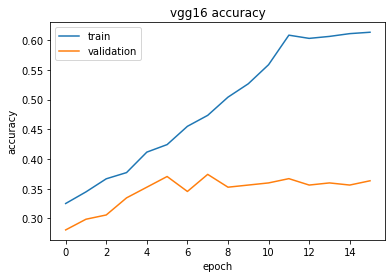

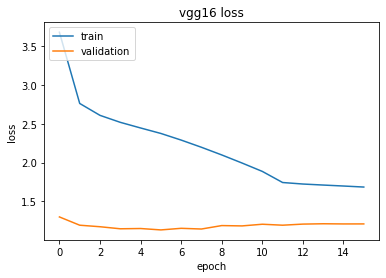

18/18 [==============================] - 1s 38ms/step
[[19 33 36]
 [36 39 32]
 [24 14 45]]
Acuracia balanceada na validacao: 0.37418791563876574


In [ ]:
cria_e_treina_rede('vgg16', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 53s 104ms/step - loss: 3.2132 - acc: 0.3486 - val_loss: 1.0852 - val_acc: 0.3957
Epoch 2/500
508/508 [==============================] - 52s 103ms/step - loss: 2.6398 - acc: 0.3630 - val_loss: 1.0634 - val_acc: 0.4173
Epoch 3/500
508/508 [=========================

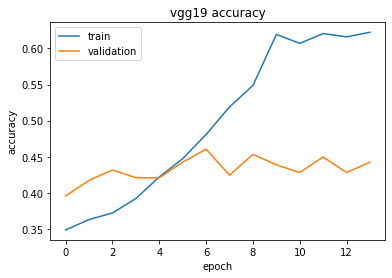

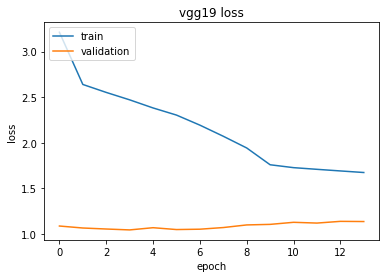

18/18 [==============================] - 1s 38ms/step
[[26 46 16]
 [29 60 18]
 [24 28 31]]
Acuracia balanceada na validacao: 0.40989872830318724


In [ ]:
cria_e_treina_rede('vgg19', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

# Resultados

Tomando como base a tabela abaixo que sinaliza a acurácia balanceada em cada uma das redes analisadas, temos que a rede EfficientNetB6 obteve a melhor acurácia balanceada com **44,23**. Em segundo lugar tivemos a EfficientNetB1 com 42,02. Dessa forma, consideraremos o EfficientNetB6 como o nosso baseline.

O EfficientNetB6 foi configurado com o earlystopping e com o Reduce learning rate que reduz a taxa de aprendizado quando não tem melhora na loss da validação.

| Rede             | Acurácia Balanceada na Validação|
| -----------------|-------------------:|
| ResNet50         | 38,72              |
| ResNet101        | 39,70              |
| ResNet152        | 34,51              |
| EfficientNetB0   | 35,38              |
| EfficientNetB1   | 42,02              |
| EfficientNetB2   | 40,77              |
| EfficientNetB3   | 39,76              |
| EfficientNetB4   | 41,30              |
| EfficientNetB5   | 37,07              |
| EfficientNetB6   | 44,23              |
| EfficientNetB7   | 38,39              |
| MobileNet        | 34,75              |
| MobileNetV2      | 32,75              |
| DenseNet121      | 37,49              |
| DenseNet169      | 38,52              |
| DenseNet201      | 37,63              |
| InceptionV3      | 36,76              |
| InceptionResNetV2| 36,91              |
| Xception         | 33,82              |
| VGG16            | 37,42              |
| VGG19            | 40,99              |